# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [1]:
%pip install --upgrade --quiet jupyter_client ipywidgets

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [2]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [4]:
batch_size = 250
valid_size = 0.2
# Define transforms
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# Create training set and define training dataloader
train_data = torchvision.datasets.MNIST(root='data', train=True, download=True, transform=transform)

# Create test set and define test dataloader
test_data = torchvision.datasets.MNIST(root='data', train=False, download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

The transforms.ToTensor() transformation is typically used to convert images from various formats  into tensors, which are multi-dimensional arrays, suitable for processing by deep learning models.

By applying the transforms.ToTensor() transformation, each image is converted into a tensor where the pixel values are normalized to the range of [0, 1]. This normalization simplifies the learning process for the model, as the pixel values become consistent and comparable across different images.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [5]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

8


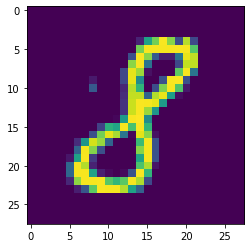

1


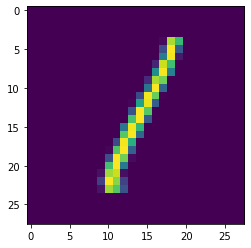

4


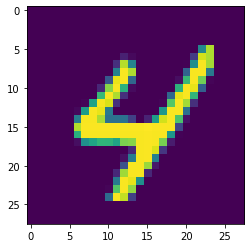

9


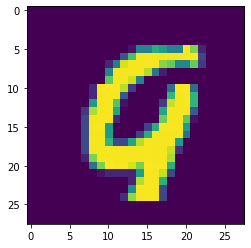

8


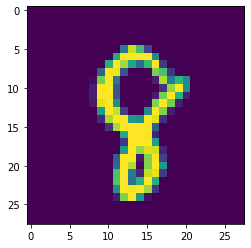

In [6]:
# Explore data
## YOUR CODE HERE ##
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [7]:
## YOUR CODE HERE ##
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        hidden_1 = 512
        hidden_2 = 512
        self.fc1 = nn.Linear(28 * 28, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

net= Net()
net.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [11]:
num_epochs = 50

# Establish a list for our history
train_loss_history = list()
val_loss_history = list()

for epoch in range(num_epochs):
    net.train()
    train_loss = 0.0
    train_correct = 0
    num_train_samples=0.0
    for i, data in enumerate(train_loader):
        # data is a list of [inputs, labels]
        inputs, labels = data
        # Pass to GPU if available.
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
        num_train_samples += labels.shape[0]
        
    print(f'Epoch {epoch + 1} training accuracy: {(100 * train_correct/num_train_samples):.2f}% training loss: {train_loss/len(train_loader):.5f}')
    train_loss_history.append(train_loss/len(train_loader))


    val_loss = 0.0
    val_correct = 0
    num_val_samples=0.0
    net.eval()
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()
        num_val_samples += labels.shape[0]
    print(f'Epoch {epoch + 1} validation accuracy: {(100 * val_correct/num_val_samples):.2f}% validation loss: {val_loss/len(test_loader):.5f}')
    val_loss_history.append(val_loss/len(test_loader))

Epoch 1 training accuracy: 99.81% training loss: 0.00584
Epoch 1 validation accuracy: 98.05% validation loss: 0.13254
Epoch 2 training accuracy: 99.73% training loss: 0.00817
Epoch 2 validation accuracy: 97.93% validation loss: 0.13036
Epoch 3 training accuracy: 99.73% training loss: 0.00811
Epoch 3 validation accuracy: 98.04% validation loss: 0.13612
Epoch 4 training accuracy: 99.74% training loss: 0.00769
Epoch 4 validation accuracy: 98.08% validation loss: 0.14387
Epoch 5 training accuracy: 99.70% training loss: 0.00925
Epoch 5 validation accuracy: 98.04% validation loss: 0.13679
Epoch 6 training accuracy: 99.80% training loss: 0.00531
Epoch 6 validation accuracy: 98.18% validation loss: 0.13827
Epoch 7 training accuracy: 99.76% training loss: 0.00700
Epoch 7 validation accuracy: 98.16% validation loss: 0.13996
Epoch 8 training accuracy: 99.71% training loss: 0.00873
Epoch 8 validation accuracy: 97.90% validation loss: 0.14414
Epoch 9 training accuracy: 99.70% training loss: 0.00931

Plot the training loss (and validation loss/accuracy, if recorded).

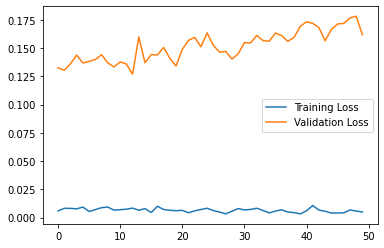

In [12]:
# Plot the training and validation loss history
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [13]:
## YOUR CODE HERE ##
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

net.eval() # prep model for evaluation

for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    test_loss += loss.item()*labels.size(0)
    _, pred = torch.max(outputs, 1)
    correct = np.squeeze(pred.eq(labels.data.view_as(pred)))
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print(f'Test Loss: {test_loss:.6f}\n')

for i in range(10):
    if class_total[i] > 0:
        print(f'Test Accuracy of {str(i)}: {100 * class_correct[i] / class_total[i]:.2f}% ({np.sum(class_correct[i])}/{ np.sum(class_total[i])})')
    else:
        print(f'Test Accuracy of {classes[i]}: N/A (no training examples)')

print(f'\nTest Accuracy (Overall): {100. * np.sum(class_correct) / np.sum(class_total):.2f}% ({np.sum(class_correct)}/{np.sum(class_total)})') 

Test Loss: 0.125659

Test Accuracy of 0: 99.39% (974.0/980.0)
Test Accuracy of 1: 99.38% (1128.0/1135.0)
Test Accuracy of 2: 98.84% (1020.0/1032.0)
Test Accuracy of 3: 98.81% (998.0/1010.0)
Test Accuracy of 4: 97.86% (961.0/982.0)
Test Accuracy of 5: 97.65% (871.0/892.0)
Test Accuracy of 6: 98.12% (940.0/958.0)
Test Accuracy of 7: 98.15% (1009.0/1028.0)
Test Accuracy of 8: 96.61% (941.0/974.0)
Test Accuracy of 9: 98.22% (991.0/1009.0)

Test Accuracy (Overall): 98.33% (9833.0/10000.0)


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [14]:
## YOUR CODE HERE ##

## Saving your model
Using `torch.save`, save your model for future loading.

In [15]:
## YOUR CODE HERE ##
torch.save(net.state_dict(), 'model.pt')